## Introduction

This is the project for the course *Algorithms for Sequence Analysis in Bioinformatics*, done in March of 2020 by Markus Toivonen.

In this project I collect a dataset that contains URLs that are considered safe and malicious. A malicious website in this context is defined as website designated for phishing purposes.

From the URLs, I extract appropriate features that can be used determine their safetiness. These features of the data are then visualized and fed into a machine learning algorithm that tries to learn from a training data set to distinguish a safe URL from a malicious one.

## Gathering data

For the phishing data, I used the [Phishtank](https://www.phishtank.com/developer_info.php) database, which contains around 10000 confirmed phishing URLs. As for the safe websites, I chose the [Cisco Umbrella](http://s3-us-west-1.amazonaws.com/umbrella-static/index.html) database, that contains 1 million of the most queried domains in the global Cisco Umbrella network. In hindsight the Cisco Umbrella dataset was not the best one to use as a whitelist data, but more on that at later parts of the Notebook.

## Imports

In [104]:
# URL imports
import requests
import json
import tld
import urllib.request
import re
from urllib.parse import urlparse
from bs4 import BeautifulSoup

# Data handling imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

## Creating URL datasets

The following script retrieves the URLs from the datasets downloaded from Phishtank and Cisco Umbrella, and creates separate files for both datasets. 

The Cisco dataset did not have the protocols in the URLs, so the script below queries the website (with `http` protocol) and returns the url that has the actual protocol of the website. The script waits only for 1 second for the server to respond, then it moves on to the next URL. The script will stop once 10000 URLs have been succesfully retrieved, and will save those to a csv file. 

In [ ]:
# Running this script takes around few hours, avoid it if you can.
# The data it generates should be already available for you! :) 

# Read original data from Phishtank
df = pd.read_csv("verified_online.csv") 

df_phish = pd.DataFrame(df.iloc[:, 1]) # Pick only the column with the URLs
df_phish.to_csv("phishing_data.csv", index = False, header = False) # Create a csv with the URLs

# Read original data from Cisco Umbrella
df = pd.read_csv("top-1m.csv").iloc[:, 1] # Pick only the URL column

urls = np.array([])
for row in df.values:
        try:
            r = requests.get("http://"+row, timeout = 1) # add http as protocol
            urls = np.append(urls, r.url) # r.url will have the ACTUAL protocol of the site, as returned by ´requests.get´
            print("URLs checked succesfully:", len(urls))
            if len(urls) >= 10000: # 
                break
        except:
            print("Connection failed:", row) # Could not manage connect to URL in 1 second

df_safe = pd.DataFrame(urls)
df_safe.to_csv("safe_data_10k.csv", index = False, header = False)

## Read datasets

The following function reads files containing the safe and phishing URLs and returns two different pandas dataframes.

In [2]:
def read_datasets():

    # Read the two data files
    df_safe = pd.read_csv("safe_data_10k.csv", names = ["url"])
    df_phish = pd.read_csv("phishing_data.csv", names = ["url"])
    return df_safe, df_phish

In [3]:
df_safe, df_phish = read_datasets()

## Parsing an URL

The following code cell disects an URL to the followings parts: `protocol`, `FQDN` (fully qualified domain name), `RDN` (registered domain name), `mld` (main level domain) and `freeURL`. freeURL refers to the parts of the URL that are fully controllable by the phisher, which means subdomains, paths and queries of the URL.

An example of a parsed URL:

| URL | Protocol |FQDN   | RDN | mld | freeURL | 
|------|------|------|------|------|------|
|   `https://www.hs.fi/uutiset/`  | `https`| `www.hs.fi`  |  `hs.fi` | `hs`  | `[www, /uutiset/]`  |

We disect the URLs to these different parts, so that we can use the properties of these different parts to extract features for each URL.

The function `parse_url` uses the functions `urlparse` (from the `urllib` library) and `get_tld` (from the `tld` library) to parse the URL into pre-defined chunks, that are stored in their respective objectives. These chunks are then retrieved in their respective functions (`get_protocol`, `get_FQDN` etc.), and the `parse_url` function returns the information described in the first paragraph. 

The library `tld` and the function `get_tld` are used, because the `urlparse` function from the `urllib` library does not recognize second level domains (or higher), for example `.co.uk`. The `tld` library tries to find the top level domain from a database curated by Mozilla. ([tld documentation](https://tld.readthedocs.io/en/latest/))

In [4]:
# Returns the protocol of the URL. If not defined, 'http' is assumed [not sure if valid assumption]
def get_protocol(urlparse_obj):
    protocol = urlparse_obj.scheme
    if protocol == '':
        return "http"
    return protocol

# Returns FQDN of URL
def get_FQDN(urlparse_obj):
    return urlparse_obj.netloc

# Returns RDN of URL
def get_RDN(tld_obj):
    return tld_obj.domain + "." + tld_obj.tld # Concatenates the domain and the top level domain

# Returns mld of URL
def get_mld(RDN):
    return RDN.split(".")[0]

# Returns a list of freeURL, that has two elements. Second element is a concatenation of path and query of URL
# Function will drop '?' [and possibly other chars] in the url that are between path and query
def get_freeURL(urlparse_obj, tld_obj):
    return [tld_obj.subdomain, urlparse_obj.path + urlparse_obj.query]

def parse_url(url):

    # tld library can sometimes fail with some weird URLs
    # also some errors might be raised in various different situations I am sure
    try: 
        # Two different objs that contain 
        urlparse_obj = urlparse(url)
        tld_obj = tld.get_tld(url, as_object = True)
        
        # Collect all parts from respective 'get' functions
        protocol = get_protocol(urlparse_obj)
        FQDN = get_FQDN(urlparse_obj)
        RDN = get_RDN(tld_obj)
        mld = get_mld(RDN)
        freeURL = get_freeURL(urlparse_obj, tld_obj)
        return url, protocol, FQDN, RDN, mld, freeURL
    
    except: # Return None if URL parsing fails for some reason
        return None

## Extractor functions

The following section contains functions that extract desired features from the different parts of URL.

We extract the following features:

1. URL length
2. FQDN length
3. mld length
4. Amount of dots in the freeURL
5. Level of domain
6. If URL contains redirection or not
7. Domain age in days (implementation given)
8. How many HREF links are found in the HTML code


The features were selected based on features used in the papers by [Aggarwal et al. (2013)](https://arxiv.org/pdf/1301.6899.pdf) and [Marchal et al. (2018)](https://arxiv.org/pdf/1510.06501.pdf).

As can be seen from the list of features, they are mostly related to the properties of the URL string (features 1-5), where as features 6-8 focus more on the actual website itself. The URL strings are interesting to look at, since often phishers often try to use obfuscation methods, which lead to longer URLs and it's subparts (as described in previous section).

The amount of features extracted could be higher, and in further development I would definitely add more features extracted via web scraping methods. Such features are well described by Marchal et. al (2018), which clearly show that looking at the contents of the website is important. From the contents we can learn for example if the phisher trying to mimic a popular website (e.g. content loaded from outside of the domain), and how the website uses links in its content (e.g. how many links to same domain or different domain).


Because I wanted to do a full ML-type project and due to lack of prior web scraping skills, I wanted have features in the dataset that sufficiently are easy to extract. Due to this reason mostly URL string based features were selected. [Marchal et al. (2018)](https://arxiv.org/pdf/1510.06501.pdf) do mention more URL string based features, but they are not explained at all (e.g. count of terms in the URL, count of terms in the mld), so I did not know exactly what they mean, thus I decided to discard them. 

An extractor function for feature 8 is implemented, but the data is not collected for the two datasets (safe and malicious links). This is because the Wi-Fi firewalls at my apartment and university block the connection to most phishing sites, thus ironically making them unavailable for web scraping.

In [114]:
# Returns domain age
def get_domain_age_in_days(domain):
    show = "https://input.payapi.io/v1/api/fraud/domain/age/" + domain
    data = requests.get(show).json()
    return data['result'] if 'result' in data else np.NaN

# Returns URL length
def get_URL_length(url):
    return len(url)

# Returns FQDN length
def get_FQDN_length(FQDN):
    return len(FQDN)

# Returns mld length
def get_mld_length(mld):
    return len(mld)

# Returns the amount of dots in freeURL
def get_amount_of_dots_in_freeURL(freeURL):
    count = 0
    for part in freeURL:
        count += part.count(".")
    return count

# Returns if the original url gets redirected or not 
def get_redirection(url):
    try:
        r = requests.get(url, timeout = 5) # 5 seconds are given to see if the URL responds or not
        if r.url == url:
            return 0
        else:
            return 1
    except: # If landing URL was not reached in time
        return np.NaN
    
# Returns how many levels does the domain have
def get_level_of_domain(RDN):
    return len(RDN.split(".")) - 1

# Returns how many HREF urls there are in the URL
def get_HREF_amount(url):
    count = 0
    try: # try because website opening might fail
        page = urllib.request.urlopen(url) # Open page
        soup = BeautifulSoup(page, features="html5lib") # Read contents with BeautifulSoup
        count += len(soup.findAll('a', attrs={'href': re.compile("^https://")})) # URLs with https
        count += len(soup.findAll('a', attrs={'href': re.compile("^http://")})) # URLs with http
        return count
    except: 
        return np.NaN

In [115]:
get_HREF_amount("https://www.hs.fi/uutiset/")

16

## Data generation

The following function creates a dataset that has the URL and its domain age in days. The parameter `N_url` defines how many URLs are going to be in the output file. Also, only URLs for which the domain age can be found, are accepted.

The dataframe that is passed as a parameter is shuffled, because for example in the Phishing data set, URLs with same domains were clumped together. Shuffling the URLs gives us more domain variance, and especially in small datasets. 

Extracting the domain age was done separately, because the querys for finding the domain age were quite slow. I wanted to have to extract the domain ages only once, so that I would have the data available and not have to query it each time I would need it.

I ended up doing datasets of 100, 1000 and 5000 URLs for both classes.

In [6]:
# Creates a file with random urls (according to N_urls)
# and their ages. Only accepts urls for which the date can be obtained
# This was done as a separate function, since querying
# urls is not very quick, and I wanted data that had the age info available
def file_with_domain_ages(df, filename, N_urls = 100):

    df_shuffled = df.sample(n = df.shape[0]).reset_index(drop=True) # Shuffles the original list of urls
    domain_ages = np.array([]).astype(int) # Where we store domain ages
    urls = np.array([]) # Where we store urls

    for row in df_shuffled.values:
        info = parse_url(row[0]) # Parse the url
        if info != None: # If parsing was succesful
            age = get_domain_age_in_days(info[3]) # Get domain age
            if age != None: # If age was obtained
                domain_ages = np.append(domain_ages, age)
                urls = np.append(urls, info[0])
            if len(domain_ages) >= N_urls: # Checks if enough urls have been gathered
                break
                
    # Creates a csv
    df_ages = pd.DataFrame({"url":urls, "domain_age": domain_ages})
    df_ages.to_csv(filename+"_"+str(N_urls)+".csv", index = False)

In [ ]:
# Creates files with URL and its corresponding domain age
file_with_domain_ages(df_phish, "phishing_data_with_domain_age", N_urls = 100)
file_with_domain_ages(df_safe, "safe_data_with_domain_age", N_urls = 100)

The following function retrieves all the features from the extractor functions, and create a dataframe with said features. The function assumes that the file that which it opens, has the domain age info in it, on the second column.

In [7]:
def extract_features(filename, col_names):
    df = pd.read_csv(filename)
    df_features = pd.DataFrame(columns = col_names)

    for row in df.values:
        try:
            url, protocol, FQDN, RDN, mld, freeURL = parse_url(row[0]) # Parse URL into pieces
            info = [url, protocol, FQDN, RDN, mld, freeURL] # Create a list where we will add all features

            info.append(row[1]) # Add domain age
            info.append(get_URL_length(url)) # Add URL length
            info.append(get_FQDN_length(FQDN)) # Add FQDN length
            info.append(get_mld_length(mld)) # Add mld length
            info.append(get_amount_of_dots_in_freeURL(freeURL)) # add amount of dots in Fre URL
            info.append(get_redirection(url)) # Adds information if there was a redirection
            info.append(get_level_of_domain(RDN)) # Adds information if there was a redirection

        except: # If parsing the url was not succesful
            info = [np.NaN] * len(col_names) # Could be replaced with doing nothing I guess
        
        df_tmp = pd.DataFrame(data = [info], columns = col_names) # Create df of URL features
        df_features = pd.concat([df_features, df_tmp], # Concat latest URL the main df 
                                ignore_index = True, sort = False) 
    return df_features

The following function combines the two datasets (safe URLs and phishing URLs) into one dataframe, which is then saved as a .csv file. The function `create_complete_dataset()` calls the `extract_features()` function to receive the feature info. All but the redirection feature are quick to extract, which is given 5 seconds as a timeout limit. 

In [8]:
def create_complete_dataset(N_url, col_names):
    filename1 = "safe_data_with_domain_age_"+str(N_url)+".csv"
    df_safe = extract_features(filename1, col_names)
    df_safe["class"] = 0 

    filename2 = "phishing_data_with_domain_age_"+str(N_url)+".csv"
    df_phish = extract_features(filename2, col_names)
    df_phish["class"] = 1

    df_all = pd.concat([df_safe, df_phish], ignore_index = True, sort = False)
    df_all.to_csv("final_data_"+str(N_url)+".csv", index = False)

In [ ]:
N_url = 100
col_names = ["url", "protocol", "FQDN", "RDN", "mld",
            "freeURL", "domain_age", "URL_length", "FQDN_length",
           "mld_length", "freeURL_dots", "redirection_status",
            "domain_level"]
create_complete_dataset(N_url, col_names)

The following function loads the final dataset, that was created with `create_complete_dataset()`. It only takes the columns that are passed in the `feature_columns` parameter. It changes `https` and `http` values at the `protocol` column to `0` and `1`, respectively.

In [61]:
def load_dataset(N_url, feature_colnames):
    df = pd.read_csv("final_data_"+str(N_url)+".csv")
    df_features = df[feature_colnames]
    df_features["protocol"].replace({"https": 0, "http": 1}, inplace = True)
    return df_features

## Visualizing data

Before implementing an ML model to predict the malicousness of an URL, we visualize a few of the features to compare the two different classes against each other.

In [116]:
N_url = 5000
feature_colnames = ["protocol", "domain_age", "URL_length", "FQDN_length",
                    "mld_length", "freeURL_dots", "redirection_status",
                    "domain_level", "class"]
df = load_dataset(N_url, feature_colnames) 
df.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,protocol,domain_age,URL_length,FQDN_length,mld_length,freeURL_dots,redirection_status,domain_level,class
0,1,2907,25,17,6,0,0.0,1,0
1,1,5639,30,22,10,0,0.0,1,0
2,0,7692,32,23,15,0,0.0,1,0
3,1,4122,40,32,17,1,0.0,1,0
4,1,7300,24,16,9,0,0.0,1,0


We plot the histograms of the URL domain ages for both classes.

It can be seen that the distribution of ages for the phishing URLs resembles an exponential distribution. For the safe URLs, the ages are more equally distributed. This confirms partly that most phishing sites are not well established domains, but rather newly formed.

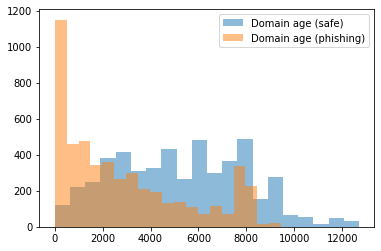

In [49]:
x = df.loc[df["class"] == 0]["domain_age"].values
y = df.loc[df["class"] == 1]["domain_age"].values
plt.hist(x, bins = 20, alpha=0.5, label= 'Domain age (safe)')
plt.hist(y, bins = 20, alpha=0.5, label= 'Domain age (phishing)')
plt.legend(loc='upper right')
plt.show()

The second feature we visualize is the URL length. Due to the obfuscation tactics used by the phishers, the URL lengths tend to be lengthier, as can be seen from the histogram.

However, the maximum value and variance of the safe URLs can be seen to be quite small. This is due to the fact that most of the safe URL data does not contain `path` and `query` parts in it's URLs. This can significantly affect the URL length, since now the URLs basicly point to the front page of the website.

This is a clearly a quite big flaw in the data, since most of the safe data URLs do not correspond to a "real-life" safe URL, because most safe URLs will always have `path` and `query` parts in them.

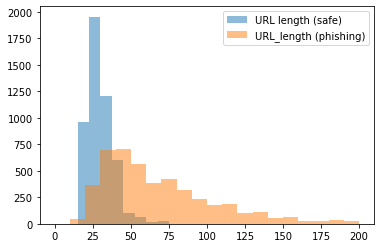

In [58]:
x = df.loc[df["class"] == 0]["URL_length"].values
y = df.loc[df["class"] == 1]["URL_length"].values
plt.hist(x, bins = 10, alpha=0.5, label='URL length (safe)', range = (0, 75))
plt.hist(y, bins = 20, alpha=0.5, label='URL_length (phishing)', range = (0, 200))
plt.legend(loc='upper right')
plt.show()

The lack of `path` and `query` will automatically affect the amount of dots in `freeURL` part, which is also a feature in the dataset. As can be seen from the histogram, most of the safe URLs have 0 dot in the `freeURL` parts, where as the amount of dots is a bit more diverse for the phishing URLs.

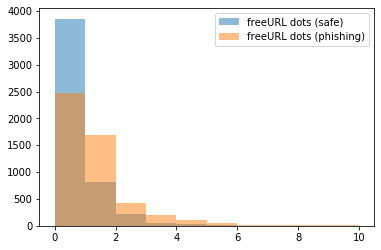

In [69]:
x = df.loc[df["class"] == 0]["freeURL_dots"].values
y = df.loc[df["class"] == 1]["freeURL_dots"].values
plt.hist(x, bins = 10, alpha=0.5, label='freeURL dots (safe)', range = (0, 10))
plt.hist(y, bins = 10, alpha=0.5, label='freeURL dots (phishing)', range = (0, 10))
plt.legend(loc='upper right')
plt.show()

These observations regarding the dataset are important to keep in mind when looking at the results of the predictor model at the next section. 

## Predicting the malicousness of an URL

In this section I create a machine learning model to predict whether an URL is malicous or not. 

In [98]:
# Load the data

N_url = 5000
feature_colnames = ["protocol", "domain_age", "URL_length", "FQDN_length",
                    "mld_length", "freeURL_dots", "redirection_status",
                    "domain_level", "class"]
df_features = load_dataset(N_url, feature_colnames)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


We drop the rows with NA values, and separate the features and the label of the URL.

In [99]:
df_features = df_features.dropna() # Drop rows with NAs
X = df_features.drop(["class"], axis = 1).values # Drop label column, so we only have our features
y = df_features["class"].values # Our labels 

Here we split the data into a training and a test set. Currently, the the test size is set to 90%. This corresponds to around 1000 URLs in total (so around 500 URLs per each class). This is mimicking what [Marchal et al. (2018)](https://arxiv.org/pdf/1510.06501.pdf) describe as their proportional training set size.

In [100]:
# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9)

Next, we scale all of our data to be between 0 and 1.

In [101]:
# Scale our training and test data 
scaler = MinMaxScaler() # Create scaler object
X_train = scaler.fit_transform(X_train) # Fits and transforms training data
X_test = scaler.transform(X_test) # Transforms test data according to the fit by training data

Now we train our classifier. As my classifying method I chose Gradient Boosting based on the paper by [Marchal et al. (2018)](https://arxiv.org/pdf/1510.06501.pdf). I treat the method mostly as a black box, but try to tune one hyperparameter which is the learning rate.

Our criterion for the best classifier is based on the validation accuracy of the model. As can be seen from the final print statement, our accuracy of predicting the malicousness of an URL is roughly 93.6%.

In [102]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1] # Define set of learning rates we iterate over

best_classifier = best_learning_rate =  best_training_acc = best_validation_acc = 0 # Init the best

for learning_rate in lr_list:
    clf = GradientBoostingClassifier(learning_rate=learning_rate) # Create object
    clf.fit(X_train, y_train) # Train
    
    val_acc = clf.score(X_test, y_test) # Validation acc
    
    if val_acc > best_validation_acc: # If we improved from last learning rate
        best_learning_rate = learning_rate
        best_training_acc = clf.score(X_train, y_train)
        best_validation_acc = val_acc
        best_classifier = clf

print("Best learning rate: ", best_learning_rate)
print("Best accuracy score (training): {0:.3f}".format(best_training_acc))
print("Best accuracy score (validation): {0:.3f}".format(best_validation_acc))

Best learning rate:  0.25
Best accuracy score (training): 1.000
Best accuracy score (validation): 0.936


Finally, we plot the confusion matrix based on the best classifier we created in the previous cell.

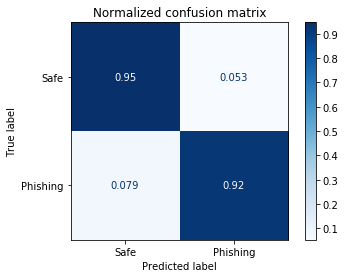

In [103]:
# Plot normalized confusion matrix
class_names = ["Safe", "Phishing"]

disp = plot_confusion_matrix(best_classifier, X_test, y_test,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             normalize= 'true')
disp.ax_.set_title(title)
plt.show()

## Discussion

The results of the model are surprisingly good, even with only 7 features and a relatively small training set. However, as mentioned the before, we have to be critical of the results due to the characteristics of the safe URL data. The model was created more as a proof of concept rather than attempt to create a high performance ML model that was tuned to the max. I was interested to see how they features I extracted would actually perform in a model.

There are multiple things to expand based on the work I for this project did: 

- The safe URL dataset should be improved to include the `path` and `query` parts for all of the safe websites. Datasets should also be larger (in literature they datasets the size of hundreds of thousands).
- More features should be extracted. Especially ones that can be obtained via web scraping methods, that are related to the contents of the website HTML code
- Conduct PCA for the continuous variables to see which features explain most of the variance (if any)
- Try different classification methods (for example SVM was mentioned in [Corona et al. (2017)](https://arxiv.org/pdf/1707.00317.pdf)) and try to tune them (e.g. hyperparameter search, regularization methods etc.)
- The workflow of the notebook could be a lot more agile. At this point it is too much like a house of cards. For example, the feature extraction into a csv file should be rebuilt so that by running 1 function call, it would create the whole dataset (`final_data_xyz.csv`). Also, the whole dataset should have been used to create a feature database, and then by changing one variable, we would be able to choose how many URLs we use for analysis etc. 